In [35]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomRotation
import torch
from torchvision.transforms import (
    Compose,
    Normalize,
    CenterCrop
)
import torchvision
import os
import math
import warnings
warnings.filterwarnings('ignore')

import math
import torch
import os
from torchvision.transforms import (
    Compose,
    Resize,
    RandomCrop
)
from torchvision.transforms import (
    RandomHorizontalFlip,
    RandomRotation,
    RandomVerticalFlip,
    RandomApply,
    InterpolationMode,
    RandomCrop,
    RandomResizedCrop
)
from matplotlib import pyplot as plt
from einops import rearrange
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [2]:
def augment_image_with_map(_img, _map):
    side_outer = 512
    angle = torch.randint(low=1, high=90, size=(1,)).item()
    
    aug1 = torch.nn.Sequential(RandomRotation((angle, angle)))
    
    side_inner = side_outer / (math.cos(math.radians(angle)) + math.sin(math.radians(angle)))
    print(f"The new h and w are: {side_inner}")
    
    state = torch.get_rng_state()
    _img = aug1(_img)

    torch.set_rng_state(state)
    _map = aug1(_map)
    
    center_x = side_outer // 2
    center_y = side_outer // 2

    half_width = side_inner // 2
    half_height = side_inner // 2 

    start_x = round(center_x - half_width)
    end_x = round(center_x + half_width)
    start_y = round(center_y - half_height)
    end_y = round(center_y + half_height)

    _img = _img[:, start_y:end_y, start_x:end_x]
    _map = _map[:, start_y:end_y, start_x:end_x]
    
    aug2 = torch.nn.Sequential(
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomResizedCrop(size=(224, 224), scale=(0.5, 2.0)))
    
    state = torch.get_rng_state()
    _img = aug2(_img)

    torch.set_rng_state(state)
    _map = aug2(_map)
    
    
    return _img, _map

In [ ]:
from torch.utils.data import Dataset
import torch
from torchvision.transforms import (
    Compose,
    ToTensor,
    PILToTensor,
    Normalize,
    CenterCrop
)
import torchvision
from PIL import Image
import os
from augment import ResizeSmall, new_data_aug_generator

##HARD CODED
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


class ImageNetDataset(Dataset):
    def __init__(self, dataset, augmentation, img_size=224):
        self.dataset = dataset 

        if not augmentation:
            small_size = 256 if img_size == 224 else img_size
            self.transform = Compose([
                ToTensor(),
                ResizeSmall(small_size),
                CenterCrop((img_size, img_size)),
                Normalize(mean=torch.tensor(mean), std=torch.tensor(std))
            ])

        else:
            first_tfl = new_data_aug_generator(simple_random_crop=False, color_jitter=0.3, img_size=img_size)
            final_tfl = [ToTensor(),
                        Normalize(
                            mean=torch.tensor(mean),
                            std=torch.tensor(std))
                        ]
            self.transform = Compose(first_tfl + final_tfl)

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        image = self.dataset[index]['image'].convert('RGB')
        label = self.dataset[index]['label']
        image = self.transform(image)  # outputs a tensor

        return (image, label)


class EvalImagesDataset(Dataset):
    def __init__(self, root_dir, data_file_path, return_labels=False):
        img_and_label_paths = torch.load(os.path.join(root_dir, data_file_path))
        self.root_dir = root_dir
        self.return_labels = return_labels
        self.imgs = img_and_label_paths['image_paths']
        self.labels = img_and_label_paths['label_paths']
        print(self.labels[0])
        print(len(self.labels))
        self.normalize = Normalize(mean=torch.tensor(mean), std=torch.tensor(std))
    
    def set_image_size(self, img_size):
        self.img_size = img_size

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image_path = self.root_dir + self.imgs[index]
        image = Image.open(image_path).convert("RGB")  # PIL
        image = ToTensor()(image)

        if self.img_size == 128:
        # default image preprecessing for 128 x 128 images
            image = ResizeSmall(192)(image)
            image = CenterCrop((self.img_size, self.img_size))(image)
        if self.img_size == 224:
        # default image preprecessing for 224 x 224 images
            image = ResizeSmall(256)(image)
            image = CenterCrop((self.img_size, self.img_size))(image)
        else:
            image = ResizeSmall(self.img_size)(image)
            image = CenterCrop((self.img_size, self.img_size))(image)

        image = self.normalize(image)
        if self.return_labels:
            label = self.labels[index]
            if type(label) is not int:
                # if split is 'test', we need to get the label this way
                label = label['original_label']
            return image, label
        else:
            return image

In [ ]:
from torch.utils.data import Dataset
import torch
from torchvision.transforms import (
    Compose,
    ToTensor,
    PILToTensor,
    Normalize,
    CenterCrop
)
import torchvision
from PIL import Image
import os
from augment import ResizeSmall, new_data_aug_generator

##HARD CODED
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


class ImageNetDataset(Dataset):
    def __init__(self, dataset, augmentation, img_size=224):
        self.dataset = dataset 

        if not augmentation:
            small_size = 256 if img_size == 224 else img_size
            self.transform = Compose([
                ToTensor(),
                ResizeSmall(small_size),
                CenterCrop((img_size, img_size)),
                Normalize(mean=torch.tensor(mean), std=torch.tensor(std))
            ])

        else:
            first_tfl = new_data_aug_generator(simple_random_crop=False, color_jitter=0.3, img_size=img_size)
            final_tfl = [ToTensor(),
                        Normalize(
                            mean=torch.tensor(mean),
                            std=torch.tensor(std))
                        ]
            self.transform = Compose(first_tfl + final_tfl)

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        image = self.dataset[index]['image'].convert('RGB')
        label = self.dataset[index]['label']
        image = self.transform(image)  # outputs a tensor

        return (image, label)


class EvalImagesDataset(Dataset):
    def __init__(self, root_dir, data_file_path, return_labels=False):
        img_and_label_paths = torch.load(os.path.join(root_dir, data_file_path))
        self.root_dir = root_dir
        self.return_labels = return_labels
        self.imgs = img_and_label_paths['image_paths']
        self.labels = img_and_label_paths['label_paths']
        print(self.labels[0])
        print(len(self.labels))
        self.normalize = Normalize(mean=torch.tensor(mean), std=torch.tensor(std))
    
    def set_image_size(self, img_size):
        self.img_size = img_size

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image_path = self.root_dir + self.imgs[index]
        image = Image.open(image_path).convert("RGB")  # PIL
        image = ToTensor()(image)

        if self.img_size == 128:
        # default image preprecessing for 128 x 128 images
            image = ResizeSmall(192)(image)
            image = CenterCrop((self.img_size, self.img_size))(image)
        if self.img_size == 224:
        # default image preprecessing for 224 x 224 images
            image = ResizeSmall(256)(image)
            image = CenterCrop((self.img_size, self.img_size))(image)
        else:
            image = ResizeSmall(self.img_size)(image)
            image = CenterCrop((self.img_size, self.img_size))(image)

        image = self.normalize(image)
        if self.return_labels:
            label = self.labels[index]
            if type(label) is not int:
                # if split is 'test', we need to get the label this way
                label = label['original_label']
            return image, label
        else:
            return image# Going to be edited more
class HirschImagesDataset(Dataset):
    def __init__(self, data_file_path, return_labels=False):
        img_and_label_paths = torch.load(os.listdir((data_file_path)))
        self.return_labels = return_labels
        self.imgs = img_and_label_paths['image_paths']
        self.labels = img_and_label_paths['label_paths']
        print(self.labels[0])
        print(len(self.labels))
        self.augment = augment_image_with_map(_img, _map)
 
    # def set_image_size(self, img_size):
    #     self.img_size = img_size
 
    def __len__(self):
        return len(self.labels)
 
    def __getitem__(self, index):
        image_path = self.imgs[index]
        image = torch.load(image_path)
 
 
        return muscle_image, muscle_map

In [26]:
class HirschImagesDataset(Dataset):
    def __init__(self, data_file_path, do_augmentation):
        self.data_file_path = data_file_path 
        self.all_paths = os.listdir((data_file_path))
        self.do_augmentation = do_augmentation
        
        if do_augmentation:
            self.augment = augment_image_with_map
        else:
            self.augment = self.identity_function
                
    def identity_function(self, img, muscle_map):
        return img, muscle_map
                
    def __len__(self):
        return len(self.all_paths)
        
    def  __getitem__(self, index):
        #loaded_tensor = torch.load(self.all_paths[index])
        loaded_tensor = torch.load(os.path.join(self.data_file_path, self.all_paths[index]))
        img = loaded_tensor['imgs']
        muscle_map = loaded_tensor['muscles_map']
        img, muscle_map = self.augment(img, muscle_map)
        return img, muscle_map

In [27]:
train_dataset = HirschImagesDataset(data_file_path="test", do_augmentation=True)
val_dataset = HirschImagesDataset(data_file_path="test1", do_augmentation=False)
test_dataset = HirschImagesDataset(data_file_path="test2", do_augmentation=False)

In [28]:
train_loader = DataLoader(train_dataset,
                          batch_size=96,
                          shuffle=True,
                          num_workers=8
)

val_loader = DataLoader(val_dataset,
                          batch_size=96,
                          shuffle=False,
                          num_workers=8
)

test_loader = DataLoader(test_dataset,
                          batch_size=96,
                          shuffle=False,
                          num_workers=8
)

In [29]:
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")

Train Dataset Length: 2
Validation Dataset Length: 2
Test Dataset Length: 2


The new h and w are: 363.4216008788375
Sample 0:


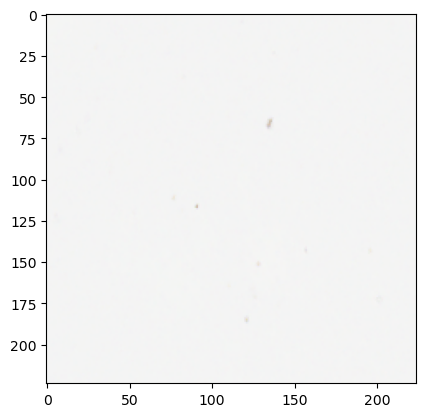

The new h and w are: 363.4216008788375
Sample 1:


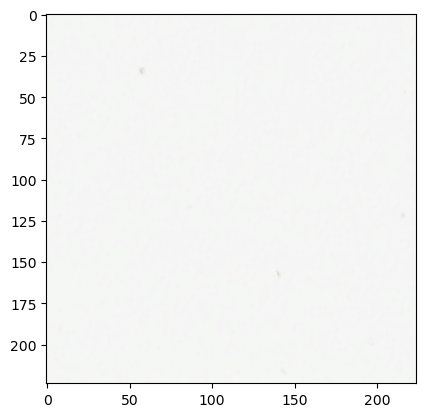

IndexError: list index out of range

In [36]:
# Function to display an image
def show_image(img_tensor):
    # Convert the tensor to a numpy array and plot it
    # You may need additional transformations depending on your data format
    plt.imshow(img_tensor.numpy().transpose(1, 2, 0))
    plt.show()

# Inspect a few samples from the train dataset
for i in range(3):
    img, muscle_map = train_dataset[i]
    print(f"Sample {i}:")
    show_image(img)  # Add any necessary processing to display the image
    # Add display or inspection for muscle_map if needed